#**Thông tin nhóm**
##Mã nhóm: 20CQ.PTDL.05
##Danh sách thành viên:
*   20120466 - Trần Thị Thu Hà
*   20120592 - Lê Minh Tiến
*   20120595 - Phạm Minh Tiến
*   20120624 - Mai Quyết Vang



#Thêm thư viện cần thiết

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load dữ liệu

In [20]:
link_p1 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p1.xlsx"
link_p2 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p2.xlsx"


In [21]:
# Đọc dữ liệu từ file Excel
Data_Train_p1 = pd.read_excel(link_p1)
Data_Train_p2 = pd.read_excel(link_p2)

# Ghép nối hai DataFrame
merged_data = pd.concat([Data_Train_p1, Data_Train_p2], ignore_index=True)

#Quan sát và phân tích tập dữ liệu (EDA)


##1. Cho biết kiểu dữ liệu của các thuộc tính


In [22]:
# Hiển thị thông tin về DataFrame
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10684 non-null  object
 1   Date_of_Journey  10684 non-null  object
 2   Source           10684 non-null  object
 3   Destination      10684 non-null  object
 4   Route            10683 non-null  object
 5   Dep_Time         10684 non-null  object
 6   Arrival_Time     10684 non-null  object
 7   Duration         10684 non-null  object
 8   Total_Stops      10683 non-null  object
 9   Additional_Info  10684 non-null  object
 10  Price            10684 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.3+ KB


##2. Đối với cột Price, cho biết:


*   Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
*   Độ lệch chuẩn của cột price?
*   Cho biết giá phân phối xung quanh trung tâm hay cách xa trung tâm?
Nhận xét về giá trị mean và median của tập dữ liệu.
*   Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không?
List item





##3. Mô tả số lượng missing value của mỗi thuộc tính


In [23]:
# 3. Mô tả số lượng missing value của mỗi thuộc tính
missing_values = merged_data.isnull().sum()
print("Số lượng missing value của mỗi thuộc tính:")
print(missing_values)

Số lượng missing value của mỗi thuộc tính:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


##4. Tính tỷ lệ % missing value của mỗi thuộc tính


In [24]:
# 4. Tính tỷ lệ % missing value của mỗi thuộc tính
missing_percentage = (missing_values / len(merged_data)) * 100
print("Tỷ lệ % missing value của mỗi thuộc tính:")
print(missing_percentage)

Tỷ lệ % missing value của mỗi thuộc tính:
Airline            0.00000
Date_of_Journey    0.00000
Source             0.00000
Destination        0.00000
Route              0.00936
Dep_Time           0.00000
Arrival_Time       0.00000
Duration           0.00000
Total_Stops        0.00936
Additional_Info    0.00000
Price              0.00000
dtype: float64


##5. Xử lý dữ liệu missing


In [25]:
# 5. Xử lý dữ liệu missing ( xóa các dòng có missing value)
merged_data.dropna(subset=['Total_Stops'], inplace=True)

##6. Outlier: sử dụng đồ thị boxplot để quan sát cột Price có tồn tại outlier không?

## Xử lí cột Duration: xử lí thành phút (int)


In [26]:
# Chuyển đổi cột 'Duration' về đơn vị phút
def convert_duration(duration):
    if 'h' in duration and 'm' in duration:
        return int(duration.split('h')[0]) * 60 + int(duration.split('h')[1].split('m')[0])
    elif 'h' in duration:
        return int(duration.split('h')[0]) * 60
    elif 'm' in duration:
        return int(duration.split('m')[0])
    else:
        return 0

merged_data['Duration'] = merged_data['Duration'].apply(convert_duration)


## Xử lí Arival-Time thành Arival-Time (định dạng giờ)

In [27]:
merged_data['Arrival_Time'] = pd.to_datetime(merged_data['Arrival_Time']).dt.strftime('%I:%M')
merged_data.head()

C:\Users\Ha\AppData\Local\Temp\ipykernel_2636\1920617473.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Arrival_Time'] = pd.to_datetime(merged_data['Arrival_Time']).dt.strftime('%I:%M')


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,170,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,01:15,445,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,1140,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,11:30,325,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,09:35,285,1 stop,No info,13302


#Visualize dữ liệu dạng bảng hoặc đồ thị:

##1. Giá vé tăng khi nào?


##2. So sánh tỷ lệ các chuyến bay thẳng và trung chuyển (có dừng)

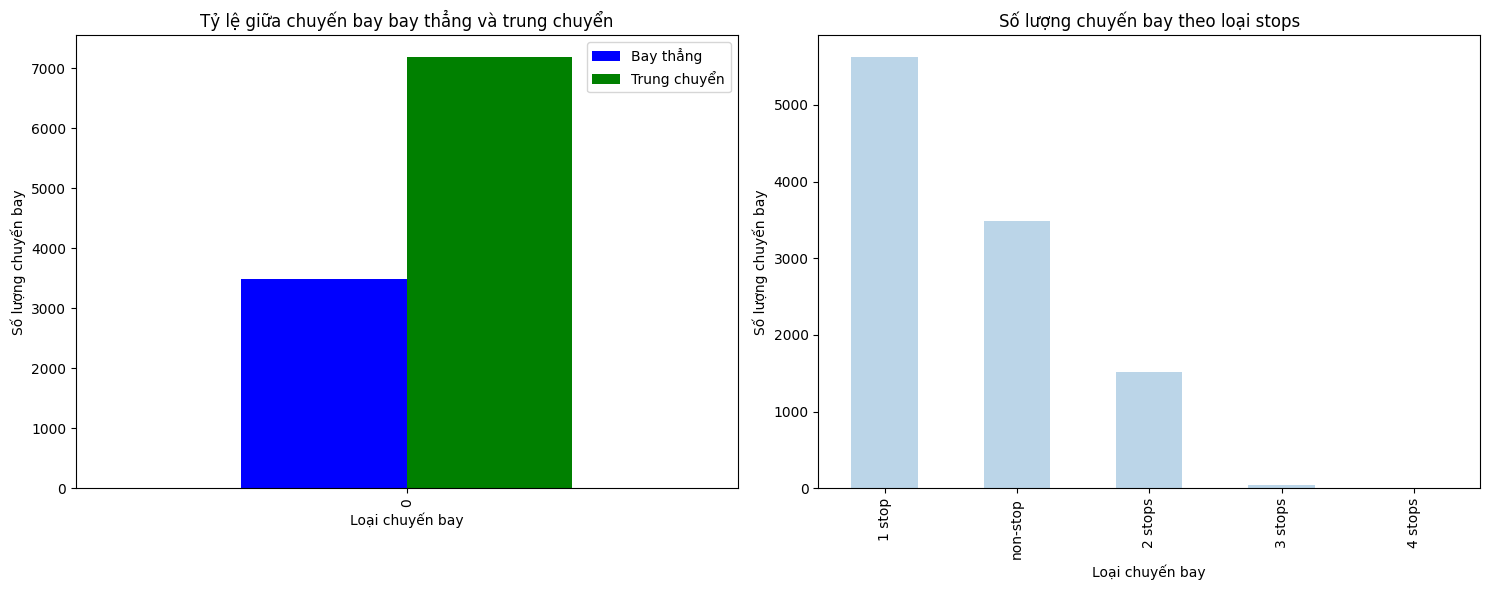

In [28]:
# Tạo DataFrame
data = pd.DataFrame(merged_data)

# Tính tỷ lệ giữa chuyến bay non-stop và chuyến bay có stops
stops_counts = data['Total_Stops'].value_counts()

# Tạo DataFrame mới chỉ chứa thông tin non-stop và stops
stops_data = pd.DataFrame({
    'Bay thẳng': stops_counts['non-stop'],
    'Trung chuyển': stops_counts.sum() - stops_counts['non-stop']
}, index=[0])

# Vẽ biểu đồ
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Biểu đồ cho tỷ lệ stops
stops_data.plot(kind='bar', color=['blue', 'green'], ax=axes[0])
axes[0].set_title('Tỷ lệ giữa chuyến bay bay thẳng và trung chuyển')
axes[0].set_xlabel('Loại chuyến bay')
axes[0].set_ylabel('Số lượng chuyến bay')

# Biểu đồ cho tỷ lệ stops_counts
stops_counts.plot(kind='bar', alpha=0.3, ax=axes[1])
axes[1].set_title('Số lượng chuyến bay theo loại stops')
axes[1].set_xlabel('Loại chuyến bay')
axes[1].set_ylabel('Số lượng chuyến bay')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Các chuyến bay trung chuyển nhiều gấp đôi những chuyến bay thẳng, đa số là một điểm dừng và ít hơn là 2 điểm dừng, từ 3 tới 4 là rất ít


##3. Nước nào có lượng chuyến bay nhiều nhất?

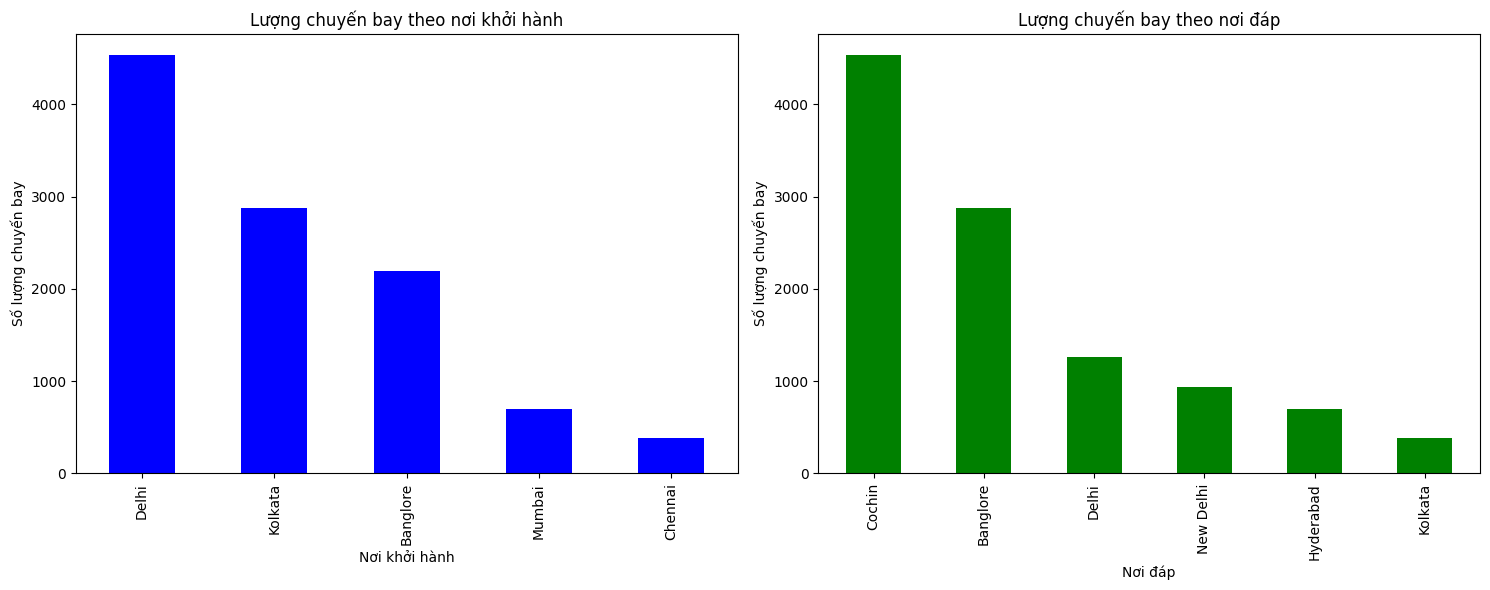

In [29]:
# Tạo DataFrame
data = pd.DataFrame(data)

# Tạo subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Biểu đồ theo nơi khởi hành
flight_count_by_source = data['Source'].value_counts()
flight_count_by_source.plot(kind='bar', color='blue', ax=axes[0])
axes[0].set_title('Lượng chuyến bay theo nơi khởi hành')
axes[0].set_xlabel('Nơi khởi hành')
axes[0].set_ylabel('Số lượng chuyến bay')

# Biểu đồ theo nơi đáp
flight_count_by_destination = data['Destination'].value_counts()
flight_count_by_destination.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_title('Lượng chuyến bay theo nơi đáp')
axes[1].set_xlabel('Nơi đáp')
axes[1].set_ylabel('Số lượng chuyến bay')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Xét theo nơi khởi hành thì Delhi là thành phố có nhiều chuyến bay đi nhất.
- Xét theo nơi đáp thì Cochin là thành phố có nhiều chuyến bay đáp đến nhất.


##4. Hãng máy bay nào được khách đặt vé nhiều/thấp nhất?


##5. Tháng nào là tháng cao điểm


##6. Giá có thay đổi tùy theo hãng hàng không hay không?


##7. Giá vé bị ảnh hưởng như thế nào khi mua vé chỉ 1 hoặc 2 ngày trước ngày khởi hành?


##8. Giá vé có thay đổi theo thời gian đi và đến không?

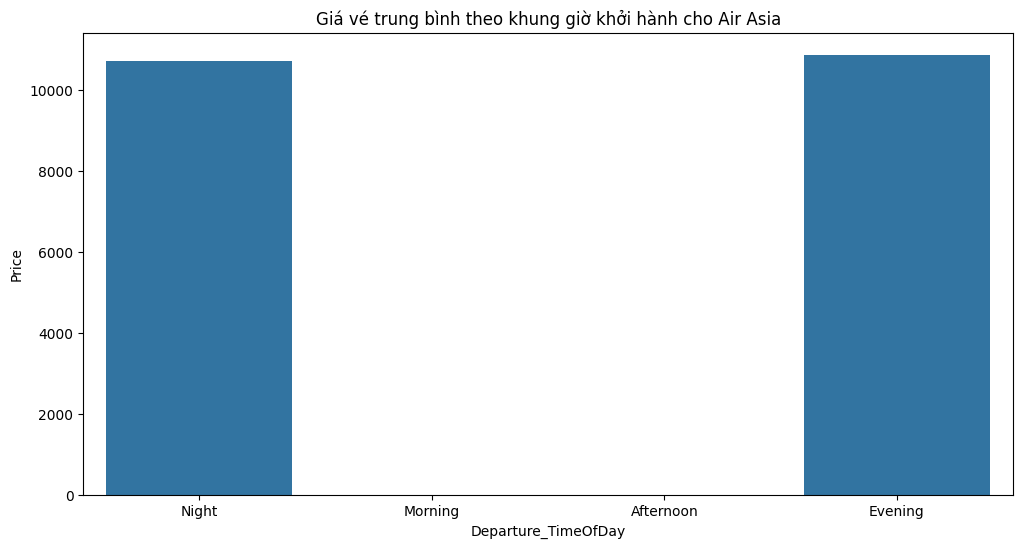

In [30]:
# Replace 'Jet Airways' with the desired airline
airline = 'Air Asia'
# Replace '01/05/2019' with the specific date you want to filter
specific_date = '01/03/2019'
specific_date = pd.to_datetime(specific_date, format='%d/%m/%Y')

source = 'Banglore'
des = 'New Delhi'
data['Departure_Hour'] = pd.to_datetime(data['Dep_Time'], format='%H:%M').dt.hour
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
# Create a new column for the time of day
data['Departure_TimeOfDay'] = pd.cut(data['Departure_Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
# Filter data for the specific airline and specific date
filtered_data = data[(data['Airline'] == airline) & (data['Date_of_Journey'] == specific_date) & (data['Source'] == source)
                     & (data['Destination'] == des)]

# Biểu đồ giá vé trung bình theo khung giờ khởi hành
plt.figure(figsize=(12, 6))
sns.barplot(x='Departure_TimeOfDay', y='Price', data=filtered_data)
plt.title(f'Giá vé trung bình theo khung giờ khởi hành cho {airline}')
plt.show()


##9. Giá thay đổi như thế nào khi thay đổi Nguồn và Điểm đến?

#Kết luận các điểm chính quan sát được từ dữ liệu từ các gợi ý trên


#Ngoài các đặc trưng trong tập dữ liệu, các yếu tố nào có khả năng ảnh hưởng đến giá vé chuyến bay?



#Dự đoán giá vé